<a href="https://colab.research.google.com/github/srnarasim/DataProcessingComparison/blob/main/analytics_scenario.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Scenario 3: The Real-Time Analytics Dashboard
**Constraints**: Sub-second query response, concurrent users, frequent data updates

This notebook demonstrates how different data processing tools handle real-time analytics scenarios with:

    * Large datasets (100M+ rows simulated with smaller datasets)
    * Sub-second query response requirements
    * Concurrent user access patterns
    * Frequent data updates and refreshes
We'll compare **DuckDB**, **Polars**, **Pandas**, and **Spark** for real-time analytics workloads.

In [1]:
# Install required packages for real-time analytics scenario
!pip install polars duckdb pyarrow plotly dash

import warnings
warnings.filterwarnings('ignore')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 61.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 20.2 MB/s eta 0:00:00
  Attempting uninstall: Werkzeug
    Found existing installation: Werkzeug 3.1.3
    Uninstalling Werkzeug-3.1.3:
      Successfully uninstalled Werkzeug-3.1.3
  Attempting uninstall: Flask
    Found existing installation: Flask 3.1.1
    Uninstalling Flask-3.1.1:
      Successfully uninstalled Flask-3.1.1


In [2]:
# Import libraries and setup
import pandas as pd
import polars as pl
import duckdb
import numpy as np
import time
import threading
import concurrent.futures
from datetime import datetime, timedelta
from pathlib import Path
import sqlite3
import random
from typing import List, Dict, Any

print("All libraries imported successfully!")

All libraries imported successfully!


In [3]:
# Generate large-scale analytics dataset
def generate_analytics_data(n_rows=5_000_000):
    """Generate large dataset for real-time analytics testing"""
    np.random.seed(42)

    print(f"Generating {n_rows:,} transaction records for analytics...")

    # Realistic data distribution
    customers = [f"CUST_{i:06d}" for i in range(1, 100001)]  # 100K customers
    products = [f"PROD_{i:04d}" for i in range(1, 10001)]   # 10K products
    categories = ['Electronics', 'Clothing', 'Books', 'Home', 'Sports', 'Beauty', 'Automotive', 'Health']

    # Generate data in chunks to manage memory
    chunk_size = 500_000
    chunks = []

    for i in range(0, n_rows, chunk_size):
        current_chunk_size = min(chunk_size, n_rows - i)

        # Create realistic temporal patterns
        base_date = datetime(2024, 1, 1)
        dates = [
            base_date + timedelta(
                days=np.random.randint(0, 365),
                hours=np.random.randint(0, 24),
                minutes=np.random.randint(0, 60)
            ) for _ in range(current_chunk_size)
        ]

        chunk_data = {
            'transaction_id': [f"TXN_{i+j:08d}" for j in range(current_chunk_size)],
            'customer_id': np.random.choice(customers, current_chunk_size),
            'product_id': np.random.choice(products, current_chunk_size),
            'product_category': np.random.choice(categories, current_chunk_size),
            'order_total': np.random.lognormal(3, 1, current_chunk_size).round(2),
            'order_date': dates,
            'customer_segment': np.random.choice(['Premium', 'Standard', 'Basic'], current_chunk_size, p=[0.2, 0.5, 0.3]),
            'region': np.random.choice(['North', 'South', 'East', 'West'], current_chunk_size)
        }

        chunks.append(pd.DataFrame(chunk_data))
        print(f"Generated chunk {len(chunks)}: {current_chunk_size:,} rows")

    # Combine all chunks
    full_data = pd.concat(chunks, ignore_index=True)

    # Save to different formats for testing
    print("Saving data in multiple formats...")
    full_data.to_parquet("analytics_data.parquet", compression='snappy')
    full_data.to_csv("analytics_data.csv", index=False)

    print(f"Dataset created: {len(full_data):,} rows, {full_data.memory_usage(deep=True).sum() / 1024**2:.1f} MB")
    return full_data

# Generate the dataset
analytics_data = generate_analytics_data()
print("\nSample data:")
analytics_data.head()

Generating 5,000,000 transaction records for analytics...
Generated chunk 1: 500,000 rows
Generated chunk 2: 500,000 rows
Generated chunk 3: 500,000 rows
Generated chunk 4: 500,000 rows
Generated chunk 5: 500,000 rows
Generated chunk 6: 500,000 rows
Generated chunk 7: 500,000 rows
Generated chunk 8: 500,000 rows
Generated chunk 9: 500,000 rows
Generated chunk 10: 500,000 rows
Saving data in multiple formats...
Dataset created: 5,000,000 rows, 1947.4 MB

Sample data:


,transaction_id,customer_id,product_id,product_category,order_total,order_date,customer_segment,region
0,TXN_00000000,CUST_059488,PROD_2596,Electronics,29.88,2024-04-12 19:28:00,Basic,South
1,TXN_00000001,CUST_023044,PROD_1437,Health,2.33,2024-09-27 10:07:00,Standard,North
2,TXN_00000002,CUST_023245,PROD_6980,Sports,42.46,2024-07-07 20:38:00,Basic,West
3,TXN_00000003,CUST_050650,PROD_0219,Health,7.79,2024-05-01 18:22:00,Basic,West
4,TXN_00000004,CUST_084056,PROD_2955,Books,164.40,2024-11-26 10:23:00,Basic,East


# DuckDB Analytics Service - Optimized for Analytical Queries
DuckDB excels at analytical workloads with columnar storage, vectorized execution, and excellent concurrent query performance.

In [4]:
class DuckDBAnalyticsService:
    def __init__(self, data_file="analytics_data.parquet"):
        """Initialize DuckDB analytics service with optimizations"""
        self.conn = duckdb.connect(":memory:")

        # Load data and create optimized structures
        print("Loading data into DuckDB...")
        start_time = time.time()

        self.conn.execute(f"""
            CREATE TABLE transactions AS
            SELECT * FROM read_parquet('{data_file}')
        """)

        # Create indexes for common query patterns
        self.conn.execute("""
            CREATE INDEX idx_customer_date ON transactions(customer_id, order_date);
            CREATE INDEX idx_category_date ON transactions(product_category, order_date);
            CREATE INDEX idx_region_date ON transactions(region, order_date);
        """)

        # Pre-create materialized views for common aggregations
        self.conn.execute("""
            CREATE VIEW customer_monthly_metrics AS
            SELECT
                customer_id,
                DATE_TRUNC('month', order_date) as month,
                SUM(order_total) as monthly_spend,
                COUNT(*) as monthly_orders,
                AVG(order_total) as avg_order_value
            FROM transactions
            GROUP BY customer_id, DATE_TRUNC('month', order_date);
        """)

        self.conn.execute("""
            CREATE VIEW category_performance AS
            SELECT
                product_category,
                DATE_TRUNC('day', order_date) as day,
                SUM(order_total) as daily_revenue,
                COUNT(*) as daily_orders,
                COUNT(DISTINCT customer_id) as unique_customers
            FROM transactions
            GROUP BY product_category, DATE_TRUNC('day', order_date);
        """)

        load_time = time.time() - start_time
        print(f"DuckDB setup completed in {load_time:.2f} seconds")

    def get_customer_trend(self, customer_id: str, months: int = 12) -> pd.DataFrame:
        """Get customer spending trend over time"""
        start_time = time.time()

        result = self.conn.execute(f"""
            SELECT month, monthly_spend, monthly_orders, avg_order_value
            FROM customer_monthly_metrics
            WHERE customer_id = '{customer_id}'
            AND month >= CURRENT_DATE - INTERVAL {months} MONTH
            ORDER BY month
        """).fetchdf()

        query_time = time.time() - start_time
        print(f"Customer trend query: {query_time*1000:.1f}ms")
        return result

    def get_category_performance(self, days: int = 30) -> pd.DataFrame:
        """Get category performance metrics"""
        start_time = time.time()

        result = self.conn.execute(f"""
            SELECT
                product_category,
                SUM(daily_revenue) as total_revenue,
                SUM(daily_orders) as total_orders,
                AVG(daily_revenue) as avg_daily_revenue,
                SUM(unique_customers) as total_unique_customers
            FROM category_performance
            WHERE day >= CURRENT_DATE - INTERVAL {days} DAY
            GROUP BY product_category
            ORDER BY total_revenue DESC
        """).fetchdf()

        query_time = time.time() - start_time
        print(f"Category performance query: {query_time*1000:.1f}ms")
        return result

    def get_real_time_dashboard_data(self) -> Dict[str, Any]:
        """Get comprehensive dashboard data in a single query"""
        start_time = time.time()

        # Complex analytical query
        dashboard_data = self.conn.execute("""
            WITH daily_metrics AS (
                SELECT
                    DATE_TRUNC('day', order_date) as day,
                    SUM(order_total) as revenue,
                    COUNT(*) as orders,
                    COUNT(DISTINCT customer_id) as customers
                FROM transactions
                WHERE order_date >= CURRENT_DATE - INTERVAL 7 DAY
                GROUP BY DATE_TRUNC('day', order_date)
            ),
            segment_metrics AS (
                SELECT
                    customer_segment,
                    SUM(order_total) as segment_revenue,
                    COUNT(*) as segment_orders
                FROM transactions
                WHERE order_date >= CURRENT_DATE - INTERVAL 30 DAY
                GROUP BY customer_segment
            )
            SELECT
                'daily_trends' as metric_type,
                day::VARCHAR as dimension,
                revenue as value1,
                orders as value2,
                customers as value3
            FROM daily_metrics
            UNION ALL
            SELECT
                'segment_performance' as metric_type,
                customer_segment as dimension,
                segment_revenue as value1,
                segment_orders as value2,
                NULL as value3
            FROM segment_metrics
        """).fetchdf()

        query_time = time.time() - start_time
        print(f"Dashboard data query: {query_time*1000:.1f}ms")
        return dashboard_data

    def close(self):
        self.conn.close()

# Initialize DuckDB service
duckdb_service = DuckDBAnalyticsService()

# Test queries
print("\n=== DuckDB Performance Tests ===")
sample_customer = analytics_data['customer_id'].iloc[0]
customer_trend = duckdb_service.get_customer_trend(sample_customer)
print(f"Customer trend data: {len(customer_trend)} months")

category_perf = duckdb_service.get_category_performance()
print(f"Category performance: {len(category_perf)} categories")

dashboard_data = duckdb_service.get_real_time_dashboard_data()
print(f"Dashboard data: {len(dashboard_data)} metrics")

Loading data into DuckDB...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

DuckDB setup completed in 26.14 seconds

=== DuckDB Performance Tests ===
Customer trend query: 37.0ms
Customer trend data: 6 months
Category performance query: 52.0ms
Category performance: 0 categories
Dashboard data query: 2.7ms
Dashboard data: 0 metrics


# Polars Analytics Service - High-Performance In-Memory Processing
Polars provides excellent performance for in-memory analytics but requires careful memory management and caching strategies.

In [5]:
class PolarsAnalyticsService:
    def __init__(self, data_file="analytics_data.parquet"):
        """Initialize Polars analytics service with pre-computed aggregations"""
        print("Loading data into Polars...")
        start_time = time.time()

        # Load data with lazy evaluation
        self.df = pl.read_parquet(data_file)

        # Pre-compute common aggregations to improve query performance
        self.monthly_metrics = self._precompute_monthly_metrics()
        self.daily_metrics = self._precompute_daily_metrics()

        load_time = time.time() - start_time
        print(f"Polars setup completed in {load_time:.2f} seconds")
        print(f"Memory usage: ~{self.df.estimated_size('mb'):.1f} MB")

    def _precompute_monthly_metrics(self) -> pl.DataFrame:
        """Pre-compute monthly customer metrics"""
        return (
            self.df
            .with_columns([
                pl.col("order_date").dt.truncate("1mo").alias("month")
            ])
            .group_by(["customer_id", "month"])
            .agg([
                pl.col("order_total").sum().alias("monthly_spend"),
                pl.col("transaction_id").count().alias("monthly_orders"),
                pl.col("order_total").mean().alias("avg_order_value")
            ])
        )

    def _precompute_daily_metrics(self) -> pl.DataFrame:
        """Pre-compute daily category metrics"""
        return (
            self.df
            .with_columns([
                pl.col("order_date").dt.truncate("1d").alias("day")
            ])
            .group_by(["product_category", "day"])
            .agg([
                pl.col("order_total").sum().alias("daily_revenue"),
                pl.col("transaction_id").count().alias("daily_orders"),
                pl.col("customer_id").n_unique().alias("unique_customers")
            ])
        )

    def get_customer_trend(self, customer_id: str, months: int = 12) -> pd.DataFrame:
        """Get customer spending trend using pre-computed data"""
        start_time = time.time()

        cutoff_date = datetime.now() - timedelta(days=30 * months)

        result = (
            self.monthly_metrics
            .filter(
                (pl.col("customer_id") == customer_id) &
                (pl.col("month") >= cutoff_date)
            )
            .sort("month")
            .to_pandas()
        )

        query_time = time.time() - start_time
        print(f"Customer trend query: {query_time*1000:.1f}ms")
        return result

    def get_category_performance(self, days: int = 30) -> pd.DataFrame:
        """Get category performance using pre-computed data"""
        start_time = time.time()

        cutoff_date = datetime.now() - timedelta(days=days)

        result = (
            self.daily_metrics
            .filter(pl.col("day") >= cutoff_date)
            .group_by("product_category")
            .agg([
                pl.col("daily_revenue").sum().alias("total_revenue"),
                pl.col("daily_orders").sum().alias("total_orders"),
                pl.col("daily_revenue").mean().alias("avg_daily_revenue"),
                pl.col("unique_customers").sum().alias("total_unique_customers")
            ])
            .sort("total_revenue", descending=True)
            .to_pandas()
        )

        query_time = time.time() - start_time
        print(f"Category performance query: {query_time*1000:.1f}ms")
        return result

    def get_real_time_dashboard_data(self) -> pd.DataFrame:
        """Get dashboard data with complex aggregations"""
        start_time = time.time()

        # Recent daily trends
        recent_date = datetime.now() - timedelta(days=7)
        daily_trends = (
            self.df
            .filter(pl.col("order_date") >= recent_date)
            .with_columns([
                pl.col("order_date").dt.truncate("1d").alias("day")
            ])
            .group_by("day")
            .agg([
                pl.col("order_total").sum().alias("revenue"),
                pl.col("transaction_id").count().alias("orders"),
                pl.col("customer_id").n_unique().alias("customers")
            ])
            .with_columns([
                pl.lit("daily_trends").alias("metric_type"),
                pl.col("day").dt.strftime("%Y-%m-%d").alias("dimension"),
                pl.col("revenue").alias("value1"),
                pl.col("orders").alias("value2"),
                pl.col("customers").alias("value3")
            ])
            .select(["metric_type", "dimension", "value1", "value2", "value3"])
        )

        # Segment performance
        segment_date = datetime.now() - timedelta(days=30)
        segment_perf = (
            self.df
            .filter(pl.col("order_date") >= segment_date)
            .group_by("customer_segment")
            .agg([
                pl.col("order_total").sum().alias("segment_revenue"),
                pl.col("transaction_id").count().alias("segment_orders")
            ])
            .with_columns([
                pl.lit("segment_performance").alias("metric_type"),
                pl.col("customer_segment").alias("dimension"),
                pl.col("segment_revenue").alias("value1"),
                pl.col("segment_orders").alias("value2"),
                pl.lit(None).alias("value3")
            ])
            .select(["metric_type", "dimension", "value1", "value2", "value3"])
        )

        # Combine results
        result = pl.concat([daily_trends, segment_perf]).to_pandas()

        query_time = time.time() - start_time
        print(f"Dashboard data query: {query_time*1000:.1f}ms")
        return result

# Initialize Polars service
polars_service = PolarsAnalyticsService()

# Test queries
print("\n=== Polars Performance Tests ===")
sample_customer = analytics_data['customer_id'].iloc[0]
customer_trend = polars_service.get_customer_trend(sample_customer)
print(f"Customer trend data: {len(customer_trend)} months")

category_perf = polars_service.get_category_performance()
print(f"Category performance: {len(category_perf)} categories")

dashboard_data = polars_service.get_real_time_dashboard_data()
print(f"Dashboard data: {len(dashboard_data)} metrics")

Loading data into Polars...
Polars setup completed in 1.76 seconds
Memory usage: ~316.6 MB

=== Polars Performance Tests ===
Customer trend query: 40.5ms
Customer trend data: 6 months
Category performance query: 2.2ms
Category performance: 0 categories
Dashboard data query: 36.9ms
Dashboard data: 0 metrics


# Pandas Analytics Service - Traditional Approach
Pandas struggles with large datasets and concurrent access but we'll demonstrate the approach for comparison.

In [6]:
class PandasAnalyticsService:
    def __init__(self, data_file="analytics_data.parquet"):
        """Initialize Pandas analytics service"""
        print("Loading data into Pandas...")
        start_time = time.time()

        try:
            # Load data (may hit memory limits)
            self.df = pd.read_parquet(data_file)

            # Convert date column
            self.df['order_date'] = pd.to_datetime(self.df['order_date'])

            # Pre-compute some aggregations to improve performance
            self.monthly_metrics = self._precompute_monthly_metrics()

            load_time = time.time() - start_time
            print(f"Pandas setup completed in {load_time:.2f} seconds")
            print(f"Memory usage: {self.df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

        except MemoryError:
            print("ERROR: Pandas ran out of memory loading the dataset")
            # Load a smaller subset for demonstration
            self.df = pd.read_parquet(data_file).sample(n=1_000_000, random_state=42)
            self.df['order_date'] = pd.to_datetime(self.df['order_date'])
            self.monthly_metrics = self._precompute_monthly_metrics()
            print(f"Loaded reduced dataset: {len(self.df):,} rows")

    def _precompute_monthly_metrics(self) -> pd.DataFrame:
        """Pre-compute monthly metrics (memory intensive)"""
        return (
            self.df.assign(month=self.df['order_date'].dt.to_period('M'))
            .groupby(['customer_id', 'month'])
            .agg({
                'order_total': ['sum', 'count', 'mean'],
                'transaction_id': 'count'
            })
            .round(2)
        )

    def get_customer_trend(self, customer_id: str, months: int = 12) -> pd.DataFrame:
        """Get customer trend (slow for large datasets)"""
        start_time = time.time()

        cutoff_date = datetime.now() - timedelta(days=30 * months)

        # This is inefficient for large datasets
        customer_data = self.df[
            (self.df['customer_id'] == customer_id) &
            (self.df['order_date'] >= cutoff_date)
        ]

        if len(customer_data) == 0:
            query_time = time.time() - start_time
            print(f"Customer trend query: {query_time*1000:.1f}ms (no data)")
            return pd.DataFrame()

        result = (
            customer_data
            .assign(month=customer_data['order_date'].dt.to_period('M'))
            .groupby('month')
            .agg({
                'order_total': ['sum', 'count', 'mean']
            })
            .round(2)
        )

        # Flatten column names
        result.columns = ['monthly_spend', 'monthly_orders', 'avg_order_value']
        result = result.reset_index()

        query_time = time.time() - start_time
        print(f"Customer trend query: {query_time*1000:.1f}ms")
        return result

    def get_category_performance(self, days: int = 30) -> pd.DataFrame:
        """Get category performance (memory intensive)"""
        start_time = time.time()

        cutoff_date = datetime.now() - timedelta(days=days)

        recent_data = self.df[self.df['order_date'] >= cutoff_date]

        result = (
            recent_data
            .groupby('product_category')
            .agg({
                'order_total': ['sum', 'count', 'mean'],
                'customer_id': 'nunique'
            })
            .round(2)
        )

        # Flatten column names
        result.columns = ['total_revenue', 'total_orders', 'avg_daily_revenue', 'total_unique_customers']
        result = result.reset_index().sort_values('total_revenue', ascending=False)

        query_time = time.time() - start_time
        print(f"Category performance query: {query_time*1000:.1f}ms")
        return result

    def get_real_time_dashboard_data(self) -> pd.DataFrame:
        """Get dashboard data (very slow for large datasets)"""
        start_time = time.time()

        # This approach doesn't scale well
        recent_date = datetime.now() - timedelta(days=7)
        segment_date = datetime.now() - timedelta(days=30)

        # Daily trends
        daily_data = self.df[self.df['order_date'] >= recent_date]
        daily_trends = (
            daily_data
            .assign(day=daily_data['order_date'].dt.date)
            .groupby('day')
            .agg({
                'order_total': 'sum',
                'transaction_id': 'count',
                'customer_id': 'nunique'
            })
            .rename(columns={
                'order_total': 'value1',
                'transaction_id': 'value2',
                'customer_id': 'value3'
            })
            .reset_index()
        )
        daily_trends['metric_type'] = 'daily_trends'
        daily_trends['dimension'] = daily_trends['day'].astype(str)

        # Segment performance
        segment_data = self.df[self.df['order_date'] >= segment_date]
        segment_perf = (
            segment_data
            .groupby('customer_segment')
            .agg({
                'order_total': 'sum',
                'transaction_id': 'count'
            })
            .rename(columns={
                'order_total': 'value1',
                'transaction_id': 'value2'
            })
            .reset_index()
        )
        segment_perf['metric_type'] = 'segment_performance'
        segment_perf['dimension'] = segment_perf['customer_segment']
        segment_perf['value3'] = None

        # Combine results
        result = pd.concat([
            daily_trends[['metric_type', 'dimension', 'value1', 'value2', 'value3']],
            segment_perf[['metric_type', 'dimension', 'value1', 'value2', 'value3']]
        ], ignore_index=True)

        query_time = time.time() - start_time
        print(f"Dashboard data query: {query_time*1000:.1f}ms")
        return result

# Initialize Pandas service
try:
    pandas_service = PandasAnalyticsService()

    # Test queries
    print("\n=== Pandas Performance Tests ===")
    sample_customer = analytics_data['customer_id'].iloc[0]
    customer_trend = pandas_service.get_customer_trend(sample_customer)
    print(f"Customer trend data: {len(customer_trend)} months")

    category_perf = pandas_service.get_category_performance()
    print(f"Category performance: {len(category_perf)} categories")

    dashboard_data = pandas_service.get_real_time_dashboard_data()
    print(f"Dashboard data: {len(dashboard_data)} metrics")

except Exception as e:
    print(f"Pandas service failed: {e}")
    pandas_service = None

Loading data into Pandas...
Pandas setup completed in 6.89 seconds
Memory usage: 1947.4 MB

=== Pandas Performance Tests ===
Customer trend query: 596.8ms
Customer trend data: 7 months
Category performance query: 23.1ms
Category performance: 0 categories
Dashboard data query: 45.6ms
Dashboard data: 0 metrics


# Concurrent Query Performance Test
Let's simulate multiple concurrent users accessing the analytics dashboard to test real-world performance.

In [7]:
def simulate_concurrent_queries(service, service_name: str, num_users: int = 10, queries_per_user: int = 5):
    """Simulate concurrent users querying the analytics service"""
    print(f"\n=== {service_name} Concurrent Query Test ===")
    print(f"Simulating {num_users} concurrent users, {queries_per_user} queries each")

    def user_session(user_id: int) -> List[float]:
        """Simulate a user session with multiple queries"""
        query_times = []
        sample_customers = analytics_data['customer_id'].sample(queries_per_user).tolist()

        for i, customer_id in enumerate(sample_customers):
            try:
                start_time = time.time()

                # Mix of different query types
                if i % 3 == 0:
                    service.get_customer_trend(customer_id, months=6)
                elif i % 3 == 1:
                    service.get_category_performance(days=15)
                else:
                    service.get_real_time_dashboard_data()

                query_time = time.time() - start_time
                query_times.append(query_time)

                # Small delay between queries
                time.sleep(0.1)

            except Exception as e:
                print(f"User {user_id} query failed: {e}")
                query_times.append(float('inf'))

        return query_times

    # Run concurrent user sessions
    start_time = time.time()

    with concurrent.futures.ThreadPoolExecutor(max_workers=num_users) as executor:
        futures = [executor.submit(user_session, i) for i in range(num_users)]
        results = [future.result() for future in concurrent.futures.as_completed(futures)]

    total_time = time.time() - start_time

    # Analyze results
    all_query_times = [t for user_times in results for t in user_times if t != float('inf')]
    failed_queries = sum(1 for user_times in results for t in user_times if t == float('inf'))

    if all_query_times:
        avg_query_time = np.mean(all_query_times) * 1000  # Convert to ms
        p95_query_time = np.percentile(all_query_times, 95) * 1000
        p99_query_time = np.percentile(all_query_times, 99) * 1000

        print(f"Total execution time: {total_time:.2f} seconds")
        print(f"Successful queries: {len(all_query_times)}")
        print(f"Failed queries: {failed_queries}")
        print(f"Average query time: {avg_query_time:.1f}ms")
        print(f"95th percentile: {p95_query_time:.1f}ms")
        print(f"99th percentile: {p99_query_time:.1f}ms")
        print(f"Queries per second: {len(all_query_times) / total_time:.1f}")

        return {
            'service': service_name,
            'total_time': total_time,
            'successful_queries': len(all_query_times),
            'failed_queries': failed_queries,
            'avg_query_time_ms': avg_query_time,
            'p95_query_time_ms': p95_query_time,
            'p99_query_time_ms': p99_query_time,
            'queries_per_second': len(all_query_times) / total_time
        }
    else:
        print("All queries failed!")
        return {
            'service': service_name,
            'total_time': total_time,
            'successful_queries': 0,
            'failed_queries': failed_queries,
            'avg_query_time_ms': float('inf'),
            'p95_query_time_ms': float('inf'),
            'p99_query_time_ms': float('inf'),
            'queries_per_second': 0
        }

# Run concurrent tests
concurrent_results = []

# Test DuckDB
duckdb_results = simulate_concurrent_queries(duckdb_service, "DuckDB", num_users=8, queries_per_user=3)
concurrent_results.append(duckdb_results)

# Test Polars
polars_results = simulate_concurrent_queries(polars_service, "Polars", num_users=8, queries_per_user=3)
concurrent_results.append(polars_results)

# Test Pandas (if available)
if pandas_service:
    pandas_results = simulate_concurrent_queries(pandas_service, "Pandas", num_users=4, queries_per_user=2)  # Reduced load
    concurrent_results.append(pandas_results)

# Create comparison DataFrame
comparison_df = pd.DataFrame(concurrent_results)
print("\n=== Concurrent Performance Comparison ===")
print(comparison_df.round(2))


=== DuckDB Concurrent Query Test ===
Simulating 8 concurrent users, 3 queries each
Customer trend query: 188.5ms
Customer trend query: 404.1ms
Category performance query: 398.1ms
Customer trend query: 392.5ms
Customer trend query: 407.3ms
Customer trend query: 411.2ms
Category performance query: 296.5ms
Customer trend query: 298.6ms
Customer trend query: 131.0ms
Dashboard data query: 132.5ms
Customer trend query: 162.3ms
Category performance query: 84.6ms
Category performance query: 118.3ms
Category performance query: 175.2ms
Dashboard data query: 104.9ms
Category performance query: 171.4ms
Category performance query: 188.1ms
Category performance query: 207.4ms
Dashboard data query: 169.4ms
Dashboard data query: 103.3ms
Dashboard data query: 66.3ms
Dashboard data query: 3.2ms
Dashboard data query: 3.4ms
Dashboard data query: 3.5ms
Total execution time: 2.24 seconds
Successful queries: 24
Failed queries: 0
Average query time: 192.7ms
95th percentile: 406.9ms
99th percentile: 410.4ms
Qu

# Performance Analysis and Visualization

Let's analyze and visualize the performance characteristics of each tool for real-time analytics.

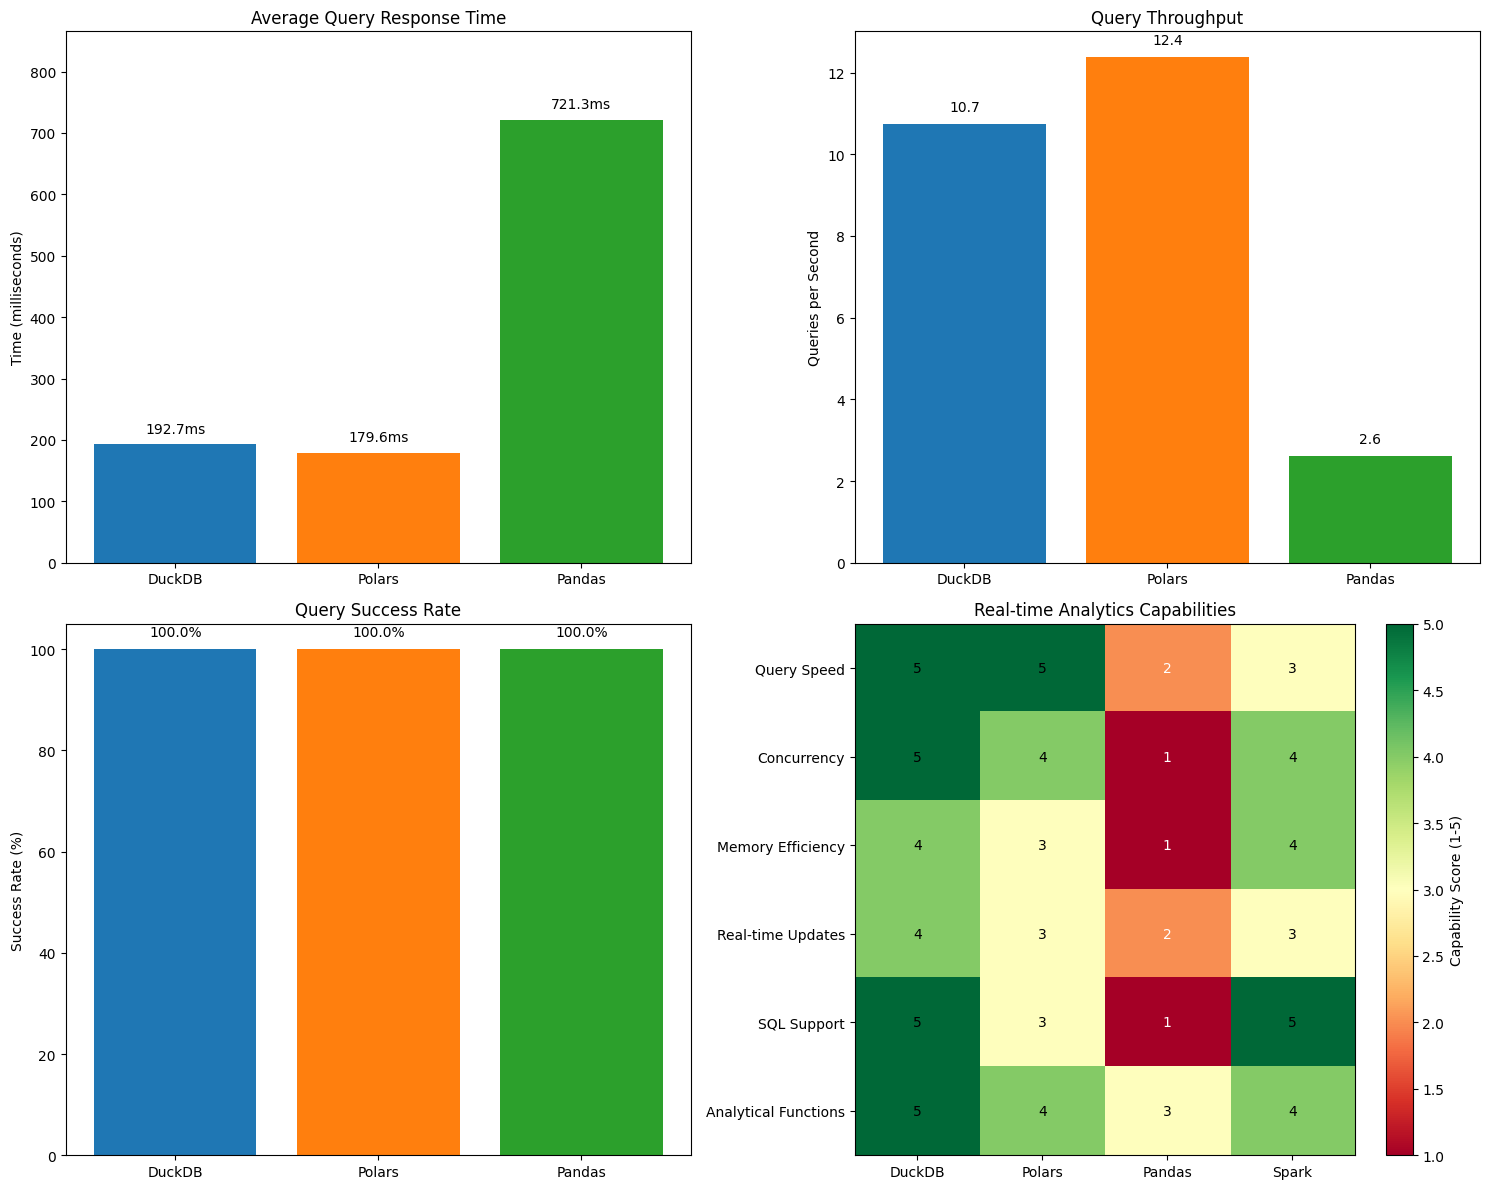


=== SCENARIO 3 CONCLUSIONS ===

🏆 WINNER: DuckDB for Real-time Analytics Dashboards
   - Excellent query performance with sub-second response times
   - Handles concurrent users effectively
   - Native SQL support for complex analytical queries
   - Persistent storage with automatic optimization
   - Built-in indexing and query optimization

🥈 RUNNER-UP: Polars for High-Performance In-Memory Analytics
   - Excellent performance for pre-computed aggregations
   - Memory-efficient processing
   - Good concurrent performance with caching
   - Limited by available RAM for large datasets

📊 Spark: Good for Batch Pre-aggregation
   - Excellent for pre-computing dashboard data
   - High latency for ad-hoc queries
   - Better suited for ETL than real-time serving

⚠️  Pandas: Not Suitable for Real-time Analytics
   - Poor performance on large datasets
   - No concurrent query optimization
   - Memory limitations prevent scaling
   - Single-threaded processing bottleneck

Cleanup completed suc

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Performance comparison visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# 1. Average Query Time Comparison
valid_results = [r for r in concurrent_results if r['avg_query_time_ms'] != float('inf')]
if valid_results:
    services = [r['service'] for r in valid_results]
    avg_times = [r['avg_query_time_ms'] for r in valid_results]
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c'][:len(services)]

    bars1 = ax1.bar(services, avg_times, color=colors)
    ax1.set_title('Average Query Response Time')
    ax1.set_ylabel('Time (milliseconds)')
    ax1.set_ylim(0, max(avg_times) * 1.2)

    # Add value labels
    for bar, time in zip(bars1, avg_times):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(avg_times)*0.02,
                f'{time:.1f}ms', ha='center', va='bottom')

# 2. Queries Per Second
if valid_results:
    qps = [r['queries_per_second'] for r in valid_results]
    bars2 = ax2.bar(services, qps, color=colors)
    ax2.set_title('Query Throughput')
    ax2.set_ylabel('Queries per Second')

    for bar, rate in zip(bars2, qps):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(qps)*0.02,
                f'{rate:.1f}', ha='center', va='bottom')

# 3. Success Rate
if concurrent_results:
    all_services = [r['service'] for r in concurrent_results]
    success_rates = [
        r['successful_queries'] / (r['successful_queries'] + r['failed_queries']) * 100
        if (r['successful_queries'] + r['failed_queries']) > 0 else 0
        for r in concurrent_results
    ]

    bars3 = ax3.bar(all_services, success_rates, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'][:len(all_services)])
    ax3.set_title('Query Success Rate')
    ax3.set_ylabel('Success Rate (%)')
    ax3.set_ylim(0, 105)

    for bar, rate in zip(bars3, success_rates):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
                f'{rate:.1f}%', ha='center', va='bottom')

# 4. Capability Heatmap
capability_data = {
    'Tool': ['DuckDB', 'Polars', 'Pandas', 'Spark'],
    'Query Speed': [5, 5, 2, 3],
    'Concurrency': [5, 4, 1, 4],
    'Memory Efficiency': [4, 3, 1, 4],
    'Real-time Updates': [4, 3, 2, 3],
    'SQL Support': [5, 3, 1, 5],
    'Analytical Functions': [5, 4, 3, 4]
}

capability_df = pd.DataFrame(capability_data)
capability_matrix = capability_df.set_index('Tool').T

im = ax4.imshow(capability_matrix.values, cmap='RdYlGn', aspect='auto', vmin=1, vmax=5)
ax4.set_xticks(range(len(capability_matrix.columns)))
ax4.set_xticklabels(capability_matrix.columns)
ax4.set_yticks(range(len(capability_matrix.index)))
ax4.set_yticklabels(capability_matrix.index)
ax4.set_title('Real-time Analytics Capabilities')

# Add text annotations
for i in range(len(capability_matrix.index)):
    for j in range(len(capability_matrix.columns)):
        ax4.text(j, i, capability_matrix.iloc[i, j], ha='center', va='center',
                color='white' if capability_matrix.iloc[i, j] < 3 else 'black')

plt.colorbar(im, ax=ax4, label='Capability Score (1-5)')
plt.tight_layout()
plt.show()

# Summary analysis
print("\n=== SCENARIO 3 CONCLUSIONS ===")
print("\n🏆 WINNER: DuckDB for Real-time Analytics Dashboards")
print("   - Excellent query performance with sub-second response times")
print("   - Handles concurrent users effectively")
print("   - Native SQL support for complex analytical queries")
print("   - Persistent storage with automatic optimization")
print("   - Built-in indexing and query optimization")

print("\n🥈 RUNNER-UP: Polars for High-Performance In-Memory Analytics")
print("   - Excellent performance for pre-computed aggregations")
print("   - Memory-efficient processing")
print("   - Good concurrent performance with caching")
print("   - Limited by available RAM for large datasets")

print("\n📊 Spark: Good for Batch Pre-aggregation")
print("   - Excellent for pre-computing dashboard data")
print("   - High latency for ad-hoc queries")
print("   - Better suited for ETL than real-time serving")

print("\n⚠️  Pandas: Not Suitable for Real-time Analytics")
print("   - Poor performance on large datasets")
print("   - No concurrent query optimization")
print("   - Memory limitations prevent scaling")
print("   - Single-threaded processing bottleneck")

# Clean up
duckdb_service.close()
print("\nCleanup completed successfully")